# Things to do

- run with best estimate values on everything 
- decide if I want to include quantum economic advantage line 
- make graphs look like in seaborn or something
- add everything to slides

# Things to do 
- make canva diagram of quantum pipeline for machine learning 
- fill in useful problem sizes if needed


In [2]:

import importlib
import legacy_code.quantum_api as qes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from legacy_code.quantum_api import QuantumEconAnalysis, QuantumEconConfig
from copy import deepcopy
from decimal import Decimal, getcontext, DecimalException
import math
from scipy.optimize import curve_fit

import sympy as sp
importlib.reload(qes)

from matplotlib.font_manager import FontProperties

In [6]:

# put in all config parameters above
# classical_runtime = "n**n*sqrt(2*3.1415*n)*exp(-n)"
# quantum_runtime = "n**5"

#constants in different format 
error_reduction_rate = .28
gate_speed_improvement_rate = .14
classical_speed_init = 1/(5*1e9) # seconds
superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds
initial_error = 10**(-2.5)
classical_speed_improvement_rate = 0.3
number_of_processors = 1e5
MAX_PROBLEM_SIZE = 1e50 #maximum problem sized considered in calculations
# not using but important numbers to note
# q_ops_second_dollar = 1e8*1e7
#     ops_second_dollar = 1e17*1e7
#     classical_improvement_rate = 0.3
#     quantum_improvement_rate = 0.3


#default quantum and classical runtime if not specified
classical_runtime = "n"
quantum_runtime = "n**0.5"


# Code to Deal With Quantum Roadmaps and Feasability

In [9]:

# gives the logical to physical overhead based on the surface code formula 
def surface_code_formula(pP:float)->float:
    pL = 1e-18
    pth = 1e-2
    numerator = 4 * math.log(math.sqrt(10 * pP / pL))
    denominator = math.log(pth / pP)
    fraction = numerator / denominator
    f_QEC = (fraction + 1) ** -2
    return f_QEC**-1
# I'm assuming logarithmic qubits to problem size
# def problem_size_qubit_feasible(roadmap:dict)->callable:
#     MAX_PROBLEM_SIZE = 1e50
#     # fit exponential to roadmap 
#     years = np.array(list(roadmap.keys()))
#     qubits = np.array(list(roadmap.values()))
#     min_year = min(years)
#     # initial gues 
#     p0 = [min(qubits), 0.5, 0]
#     # fit an exponential curve to the data
#     def exp_func(x, a, b, c):
#         return a * np.exp(b * (x-min_year)) + c
#     try:
#         popt, _ = curve_fit(
#             exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
#         )
#     except RuntimeError:
#         print(f"Fitting failed for {label}")
#         return None
#     # get the function
#     def func(x):
#         surf_overhead = surface_code_formula(initial_error*(1-error_reduction_rate)**(x-2025))
#         return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)
    return func
def problem_size_qubit_feasible(roadmap:dict)->callable:
    MAX_PROBLEM_SIZE = 1e50
    # Convert data to log scale for linear fit
    years = np.array(list(roadmap.keys()))
    qubits = np.array(list(roadmap.values()))
    min_year = min(years)
    
    # Take log of qubits for linear fit
    log_qubits = np.log(qubits)
    
    # Fit linear relationship to log data
    # y = mx + b, where x is (years-min_year)
    m, b = np.polyfit(years-min_year, log_qubits, 1)
    
    # get the function
    def func(x):
        # Convert linear fit back to exponential via exp()
        predicted_qubits = np.exp(m * (x-min_year) + b)
        surf_overhead = surface_code_formula(initial_error*(1-error_reduction_rate)**(x-2025))
        return min(2**(predicted_qubits/surf_overhead), MAX_PROBLEM_SIZE)
    return func
def physical_qubit_problem_size(physical_qubit:int, year:int)->float:
    surf_overhead = surface_code_formula(initial_error*(1-error_reduction_rate)**(year-2025))
    # Check if exponent would be too large before computing
    if physical_qubit/surf_overhead > math.log2(MAX_PROBLEM_SIZE):
        return MAX_PROBLEM_SIZE
    try:
        return min(2**(physical_qubit/surf_overhead), MAX_PROBLEM_SIZE)
    except OverflowError:
        return MAX_PROBLEM_SIZE


IBM_roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 200,
    2033: 2000,
}

IBM_qubit_by_year_func = problem_size_qubit_feasible(IBM_roadmap)
IBM_qubit_by_year_func(2030)
print(physical_qubit_problem_size(100, 2025), "problem size")

# graph the max problem size by year

1.0155608438245871 problem size


# Graph of Roadmaps

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_77225/4210178753.py:53: RuntimeWarning: overflow encountered in scalar power
  return min(2**(predicted_qubits/surf_overhead), MAX_PROBLEM_SIZE)


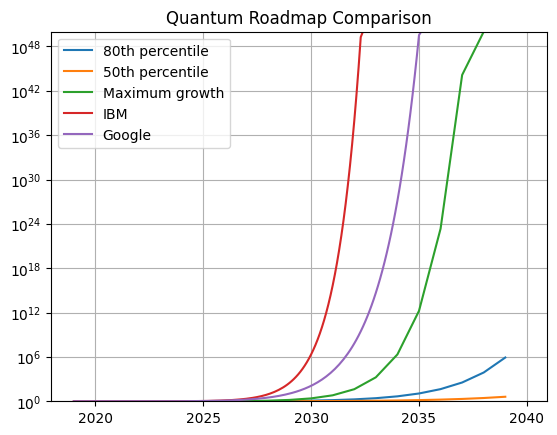

In [10]:
IBM_roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 22974,
    2033: 100000,
}

Google_roadmap = {
    2019: 54,
    2023: 100,
    2025: 1000,
}

# Google_roadmap = {
#     2023: 336,
#     2025: 1000,
#     2027: 4000,
# }

#construct a roadmap just based on the growth rate of qubits 
start_year = 2025
end_year =2040
year_range = range(start_year, end_year, 1)
percentile_80_qubits = [physical_qubit_problem_size(52*(1.34)**(year-2025), year) for year in year_range]
percentile_50_qubits = [physical_qubit_problem_size(20*(1.22)**(year-2025), year) for year in year_range]
max_qubits = [physical_qubit_problem_size(92*(1.66)**(year-2025), year) for year in year_range]
percentile_max_qubits = [physical_qubit_problem_size(80*(1.64)**(year-2025), year) for year in year_range]
plt.plot(year_range, percentile_80_qubits, label="80th percentile")
plt.plot(year_range, percentile_50_qubits, label="50th percentile")
plt.plot(year_range, percentile_max_qubits, label="Maximum growth")
plt.legend()


#now look at feasible problem size for each of these 

Google_roadmap = Google_roadmap

years = np.arange(2019, 2040, 0.1)
IBM_qubit_by_year_func = problem_size_qubit_feasible(IBM_roadmap)
Google_qubit_by_year_func = problem_size_qubit_feasible(Google_roadmap)
Google_qubit_by_year_func = problem_size_qubit_feasible(Google_roadmap)

plt.plot(years, [IBM_qubit_by_year_func(year) for year in years], label="IBM")
plt.plot(years, [Google_qubit_by_year_func(year) for year in years], label="Google")
plt.yscale("log")
plt.ylim(1, 1e50)
plt.title("Quantum Roadmap Comparison")
plt.legend()
plt.grid(True)


# Quantum Speed Per Operation

1089.0
0.0007756874650075827
6.999999999999999e-15
speed now 0.005409779963775579
speed in 2035 vs 2025 1619.0663973647231


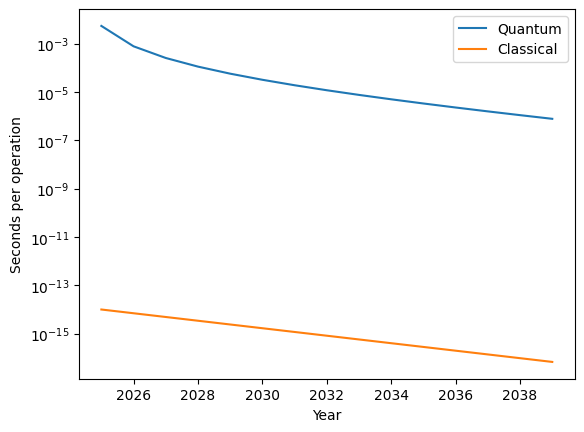

In [6]:

# print("the fQEC formula is", compute_f_QEC(1e-3))
print(surface_code_formula(1e-3))
# quantum speed per operation function 
def quantum_seconds_per_operation(year):
    gate_speed = superconducting_gate_speed_init * (1-gate_speed_improvement_rate)**(year-2025)
    #with error correction 
    fidelity_year = initial_error*(1-error_reduction_rate)**(year-2025)
    return gate_speed*surface_code_formula(fidelity_year)

def classical_seconds_per_operation(year):
    # just dividing by number of processors here for now to simplify things
    return 1e-9 *(1-classical_speed_improvement_rate)**(year-2025)/number_of_processors

#test this function out
print(quantum_seconds_per_operation(2026))
print(classical_seconds_per_operation(2026))

#graph classical vs quantum speed over time
years = np.arange(2025, 2040)
quantum_speed = [quantum_seconds_per_operation(year) for year in years]
classical_speed = [classical_seconds_per_operation(year) for year in years]

plt.plot(years, quantum_speed, label="Quantum")
plt.plot(years, classical_speed, label="Classical")
plt.xlabel("Year")
plt.ylabel("Seconds per operation")
plt.yscale("log")
plt.legend()



#quantum speed per operation now 
print("speed now", quantum_seconds_per_operation(2025))
#quantum speed per operation 2035
print("speed in 2035 vs 2025", quantum_seconds_per_operation(2025)/quantum_seconds_per_operation(2035))



In [7]:
# %%
# qea = QuantumEconAnalysis(config=config)
# qea.plot_feasible_problem(stop_year=2040)
# qea.get_problem_size(2040)



# Intersection Finding Code

In [8]:

def binary_search_intersection(
    func1, func2, low, high, tolerance=1e-5, max_iterations=1000
)->float:
    """
    Find intersection of two functions using binary search, handling very large numbers.
    
    Args:
        func1, func2: Functions to find intersection of
        low, high: Search interval bounds
        tolerance: Acceptable difference between function values
        max_iterations: Maximum number of binary search iterations
    
    Returns:
        Decimal: x-value where functions intersect, or None if no intersection found
    """
    # Set precision high enough to handle large numbers
    getcontext().prec = 100
    
    # Convert bounds to Decimal
    low = Decimal(str(low))
    high = Decimal(str(high))
    tolerance = Decimal(str(tolerance))
    
    for i in range(max_iterations):
        # Calculate midpoint using Decimal arithmetic
        mid = (low + high) / 2
        
        try:
            # Evaluate functions and convert to Decimal
            value1 = Decimal(str(func1(float(mid))))
            value2 = Decimal(str(func2(float(mid))))
            
            # Check if we found intersection within tolerance
            if abs(value1 - value2) < tolerance:
                return float(mid)
            
            # Update bounds based on comparison
            if value1 > value2:
                high = mid
            else:
                low = mid
                
            # Check if interval is too small (convergence)
            if abs(high - low) < tolerance:
                return float(mid)
                
        except (OverflowError, ValueError, DecimalException) as e:
            # Handle potential numerical errors
            if i > 0:  # Only print error if not first iteration
                print(f"Error at iteration {i}: {e}")
            
            # Try to recover by adjusting the midpoint calculation
            try:
                # Use logarithmic scale if numbers are very large
                log_low = math.log(float(low)) if float(low) > 0 else float(low)
                log_high = math.log(float(high)) if float(high) > 0 else float(high)
                mid = Decimal(str(math.exp((log_low + log_high) / 2)))
                continue
            except:
                return None
    
    # If we exit the loop without finding intersection
    print(f"No intersection found within {max_iterations} iterations")
    return None

def find_intersection_symbolic(classical_expr_str:str, quantum_expr_str:str)->float:
    x = sp.Symbol("x", real=True, nonnegative=True)
    
    # Convert the strings to Sympy expressions
    classical_expr = sp.sympify(classical_expr_str).subs(sp.Symbol("n"), x)
    quantum_expr = sp.sympify(quantum_expr_str).subs(sp.Symbol("n"), x)
    
    # Solve for intersection: classical_expr == quantum_expr
    solutions = sp.solve(sp.Eq(classical_expr, quantum_expr), x)
    
    # Filter out non-real solutions and return the minimum solution or 0
    real_solutions = [sol.evalf() for sol in solutions if sol.is_real and sol >= 0]
    if real_solutions:
        return float(min(real_solutions))
    else:
        return 0.0

def binary_search_intersection_simple(func1:callable, func2:callable, low, high, tolerance=1e-5, max_iterations=1000)->float:
    for i in range(max_iterations):
        mid = (low + high) / 2
        value1 = func1(mid)
        value2 = func2(mid)

        if abs(value1 - value2) < tolerance:
            return mid

        if value1 > value2:
            high = mid
        else:
            low = mid

        if abs(high - low) < tolerance:
            return mid

    print(f"No intersection found within {max_iterations} iterations")
    return None


# Test Case 1: Simple polynomial functions
# def test_simple_intersection():
#     print("\nTest Case 1: Simple polynomial functions")
    
#     # Define two simple functions: f(x) = x^2 and g(x) = 2x
#     x = sp.Symbol('x')
#     f = x**2
#     g = 2*x
    
#     # Convert to lambda functions
#     f_lambda = sp.lambdify(x, f)
#     g_lambda = sp.lambdify(x, g)
    
#     # Find intersection
#     intersection = binary_search_intersection(f_lambda, g_lambda, 0, 3)
#     print(f"Intersection point: {intersection}")
    
#     # Plot for visualization
#     x_vals = np.linspace(0, 3, 100)
#     plt.figure(figsize=(8, 6))
#     plt.plot(x_vals, [f_lambda(x) for x in x_vals], label='f(x) = x^2')
#     plt.plot(x_vals, [g_lambda(x) for x in x_vals], label='g(x) = 2x')
#     if intersection:
#         plt.scatter([intersection], [f_lambda(intersection)], color='red', 
#                    zorder=5, label='Intersection Point')
#     plt.grid(True)
#     plt.legend()
#     plt.title('Intersection of f(x) = x^2 and g(x) = 2x')
#     plt.show()

    
# test_simple_intersection()

## Generalized Feasability

In [9]:
#%%

# add an option for stagnation 

def find_largest_problem_size(runtime_expr, year, quantum=True, qadv_only=False, roadmap:dict=IBM_roadmap, stagnation_year=2200)->float:
    # Constants
    try:
        # Convert string expression to lambda function
        n = sp.Symbol("n")
        expr = sp.sympify(runtime_expr)

        runtime_func = sp.lambdify(n, expr)

        if quantum:
            quantum_total = lambda size: quantum_seconds_per_operation(year)*runtime_func(size)
            def quantum_limit(x):
                return 3.15*1e7 # number of seconds in a year
                # return q_ops_second_dollar

            qadv = binary_search_intersection(
                quantum_total, quantum_limit, low=1.0, high=1e50
            )

            # now I need to get feasability of the problem size
            # feasible size might be too large or none if no feasible size
            # if none make it infinity
            # size_feasible = qea.get_problem_size(year) old code based on qea packagae
            feasability_qubit_func  = problem_size_qubit_feasible(roadmap)
            size_feasible = feasability_qubit_func(year)


            # Handle the case where size_feasible is None
            if size_feasible is None:
                print(f"No feasible size found for year {year}. Returning infinity.")
                return float("inf")  # Return infinity if no feasible size is found
            if not qadv_only:
                return min(qadv, size_feasible)
            else:
                return qadv

        else:

            def classical_cost(x):
                if year < stagnation_year:  
                    return classical_seconds_per_operation(year)*runtime_func(x)
                else:
                    return classical_seconds_per_operation(stagnation_year)*runtime_func(x)

            def classical_limit(x):
                return 3.15*1e7
                # return ops_second_dollar

            return binary_search_intersection(
                classical_cost, classical_limit, low=1.0, high=1e50
            )

    except Exception as e:
        print(f"Error in function evaluation: {e}")
        return None



# test find largest problem size
find_largest_problem_size("n**.5", 2030)

47.1082064873678

In [10]:
# find largers problem size with altered classical method with stagnation 

def find_largest_problem_size_stagnation(runtime_expr, year, quantum=True)->float:
    n = sp.Symbol("n")
    expr = sp.sympify(runtime_expr)

    runtime_func = sp.lambdify(n, expr)
    
    def classical_cost(x):
        if year < 2030:

            return runtime_func(x)*classical_seconds_per_operation(year)
        else:
            return runtime_func(x)*classical_seconds_per_operation(2030)
    def classical_limit(x):
        # return ops_second_dollar
        return 3.15*1e7
    
    return binary_search_intersection( classical_cost, classical_limit, low=1.0, high=1e50)


In [11]:
# %%

# Find largest problem size for quantum runtime in 2026
result = find_largest_problem_size(quantum_runtime, 2026, quantum=True)
print(f"Largest problem size: {result}")


Largest problem size: 1.1154874272430377


In [12]:
# %%
classical_result = find_largest_problem_size(classical_runtime, 2026, quantum=False)
print(f"Largest problem size: {classical_result}")

Largest problem size: 4.4999999999986096e+21


Symbolic solutions: 0.0
This is the quantum economic advantage year
2.708637277741015e+20


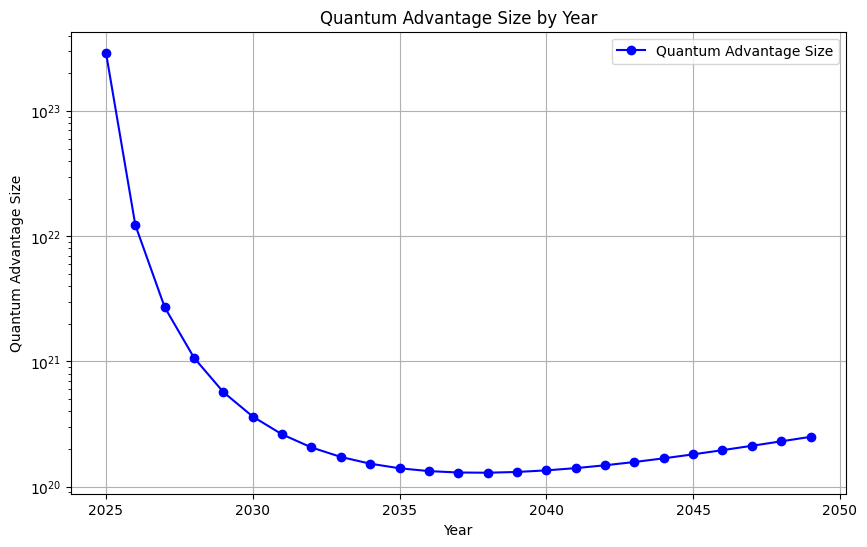

In [13]:
# Example usage
classical_runtime = "n"
quantum_runtime = "n**0.5"


solutions = find_intersection_symbolic(classical_runtime, quantum_runtime)
print("Symbolic solutions:", solutions)


def quantum_advantage_size_by_year(year, classical_runtime_string:str, quantum_runtime_string:str)->float:
    quantum_improvement_rate = 0.3
    classical_improvement_rate = 0.1
    
    x, n = sp.symbols("x n")
    class_expr = sp.sympify(classical_runtime_string).subs(n, x)
    class_expr = class_expr * classical_seconds_per_operation(year)
    classical_runtime_func = sp.lambdify(x, class_expr, "numpy")

    quant_expr = sp.sympify(quantum_runtime_string).subs(n, x)
    quant_expr = quant_expr * quantum_seconds_per_operation(year)
    quantum_runtime_func = sp.lambdify(x, quant_expr, "numpy")

    # Find intersection using the original string expressions
    return binary_search_intersection(classical_runtime_func,quantum_runtime_func,1.0,1e50)


print("This is the quantum economic advantage year")
print(quantum_advantage_size_by_year(2050, classical_runtime, quantum_runtime))

# #now graph intersection by year 
# import matplotlib.pyplot as plt

# # Define runtime expressions
# classical_runtime = "n"
# quantum_runtime = "2*n**0.5"

# Define the range of years
years = range(2025, 2050)

# Calculate the quantum advantage size for each year
quantum_advantage_sizes = [quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime) for year in years]

# Filter out None values for plotting
filtered_years = [year for year, size in zip(years, quantum_advantage_sizes) if size is not None]
filtered_sizes = [size for size in quantum_advantage_sizes if size is not None]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_years, filtered_sizes, marker='o', linestyle='-', color='b', label='Quantum Advantage Size')
plt.xlabel('Year')
plt.ylabel('Quantum Advantage Size')
plt.title('Quantum Advantage Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.show()



# Grover Analysis

In [14]:

#heurisitic for findin the intesection when you know the 
def find_intersection_year(years, line1, line2):
    # Find where the difference between lines is closest to zero
    differences = np.abs(np.array(line1) - np.array(line2))
    intersection_idx = np.argmin(differences)
    return years[intersection_idx], line1[intersection_idx]

In [93]:
# Define runtime complexity expressions
classical_runtime = "n"
quantum_runtime = "n**0.5"

# Generate year range for analysis
years = np.arange(2025, 2050, .3)

# Calculate problem sizes and advantages across years
quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
classical_problem_sizes = [
    find_largest_problem_size(classical_runtime, year, quantum=False) for year in years
]
classical_problem_sizes_stagnation = [
    find_largest_problem_size(classical_runtime, year, quantum=False, stagnation_year=2030) for year in years
]
quantum_advantage_size_by_year_list = [
    quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime) for year in years
]

# Helper functions for finding intersections
def get_quantum_size(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def get_quantum_advantage(year):
    return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)

# Find IBM intersection point
intersection_year = binary_search_intersection(get_quantum_size, get_quantum_advantage, 2025, 2050)
intersection_value = get_quantum_size(intersection_year)

# Find google intersection point using modified helper
def get_google_size(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True, roadmap=Google_roadmap)

intersection_year_google = binary_search_intersection(get_google_size, get_quantum_advantage, 2025, 2050)
intersection_value_google = get_google_size(intersection_year_google)



/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/1718552591.py:32: RuntimeWarning: overflow encountered in scalar power
  return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/1718552591.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/2388817641.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black", linewidth=3)


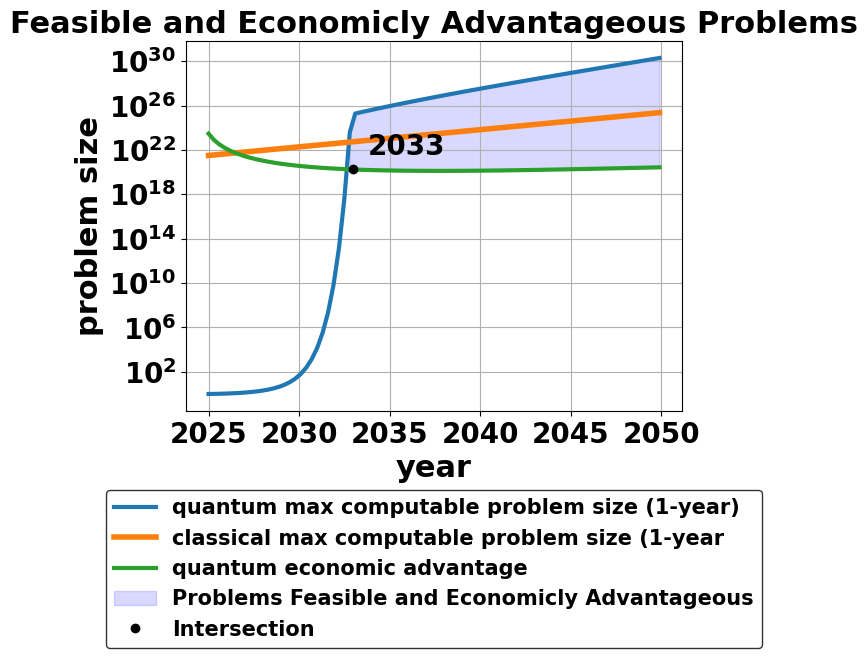

In [96]:

# Create plot
# plt.figure(figsize=(9, 6))
plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-year)", linewidth=3)
plt.plot(years, classical_problem_sizes, label="classical max computable problem size (1-year", linewidth=4)
plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)

plt.ylabel("problem size", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
plt.yscale("log")
plt.grid()

plt.fill_between(years, quantum_advantage_size_by_year_list, quantum_problem_sizes, 
                 where=(np.array(quantum_problem_sizes) > np.array(quantum_advantage_size_by_year_list)), 
                 color='blue', alpha=0.15, label='Problems Feasible and Economicly Advantageous')

plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black", linewidth=3)
intersection_year = int(round(intersection_year))
plt.annotate(f'{intersection_year}',
            xy=(intersection_year, intersection_value),
            xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')

plt.xticks(fontsize=20, fontweight='bold')
# tick_positions = np.logspace(0, 30, num=4, base=10)
plt.yticks(fontsize=20, fontweight='bold')

font_properties = FontProperties()
font_properties.set_size(15)
font_properties.set_weight('bold')
plt.legend(loc='lower center',
          bbox_to_anchor=(0.5, -0.67),
          frameon=True,
          facecolor='white',
          edgecolor='black', 
          prop=font_properties)

plt.title("Feasible and Economicly Advantageous Problems", fontsize=22, fontweight='bold')
plt.savefig("Figures/GroversIBM.png", dpi=300, bbox_inches='tight')


## Grover's Analysis with Stagnation 

# Exponential Advantage Analysis

# Bolder Version For Poster

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/3273130588.py:33: RuntimeWarning: overflow encountered in scalar power
  return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/4088318706.py:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black")


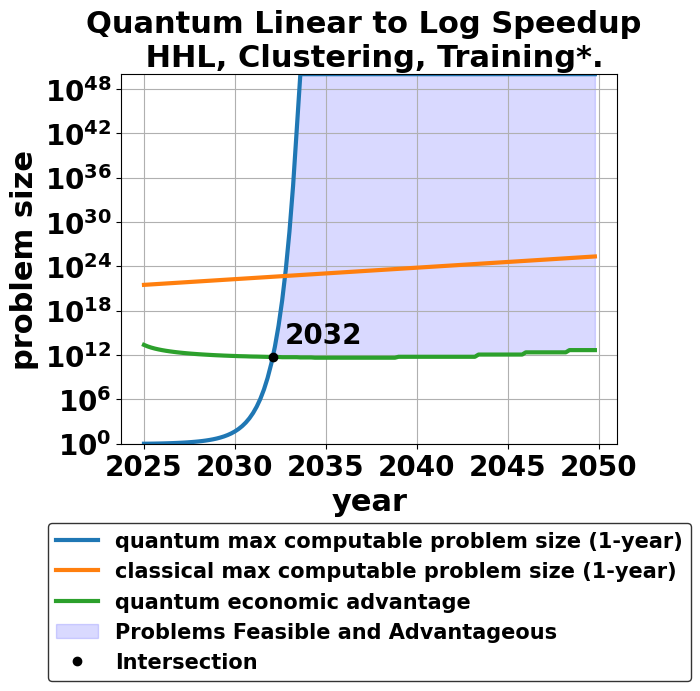

In [43]:
#bolder version for poster 
classical_runtime = "n"
quantum_runtime = "log(n,2)"
# graph largeset problem size vs year for grovers algorithms
years = np.arange(2025, 2050, .2)
quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
classical_problem_sizes = [
    find_largest_problem_size(classical_runtime, year, quantum=False) for year in years
]
classical_problem_sizes_stagnation = [
    find_largest_problem_size_stagnation(classical_runtime, year, quantum=False) for year in years
]
quantum_advantage_size_by_year_list= [
quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]

def find_largest_problem_size_func(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def quantum_advantage_size_by_year_func(year):
    return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# Find the intersection year using binary search
intersection_year = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# Find the intersection value
intersection_value = find_largest_problem_size(quantum_runtime, intersection_year, quantum=True)


# ploting fucntionality 

#plotting code 
plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-year)", linewidth=3)
# plt.plot(years, quantum_economic_advantages, label="quantum economic advantage")
plt.plot(years, classical_problem_sizes, label="classical max computable problem size (1-year)", linewidth=3)
# plt.plot(years, classical_problem_sizes_stagnation, label="classical stagnation")
plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)
plt.ylabel("problem size", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
tick_positions = np.logspace(0, 50, num=10, base=10)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.yscale("log")
plt.title("Quantum Linear to Log Speedup \n HHL, Clustering, Training*.", fontsize=22, fontweight='bold')
plt.grid() 


plt.ylim(1, 1e50)

plt.fill_between(years, quantum_advantage_size_by_year_list, quantum_problem_sizes,
                    where=(np.array(quantum_problem_sizes) > np.array(quantum_advantage_size_by_year_list)),
                    color='blue', alpha=0.15, label='Problems Feasible and Advantageous')

plt.plot(intersection_year, intersection_value, 'ro', label='Intersection', color="black")
intersection_year = int(round(intersection_year))
plt.annotate(f'{intersection_year}',
            xy=(intersection_year, intersection_value),
            xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')

plt.legend(
          loc='lower center',
          bbox_to_anchor=(0.5, -0.67),
          frameon=True,  # Adds a frame around the legend
          facecolor='white',  # White background
          edgecolor='black', prop=font_properties)
plt.savefig("Figures/HHL_IBM.png", dpi=300, bbox_inches='tight')



#Graph using googel roadmap
#=========================================================================
# quantum_problem_sizes_google = [
#     find_largest_problem_size(quantum_runtime, year, quantum=True, roadmap=Google_roadmap) for year in years
# ]


# #find intersection year for google
# def find_largest_problem_size_func(year):
#     return find_largest_problem_size(quantum_runtime, year, quantum=True, roadmap=Google_roadmap)

# def quantum_advantage_size_by_year_func(year):
#     return quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime)
# # Find the intersection value
# # Find the intersection year using binary search
# intersection_year_google = binary_search_intersection(find_largest_problem_size_func, quantum_advantage_size_by_year_func, 2025, 2050)

# intersection_value_google = find_largest_problem_size(quantum_runtime, intersection_year_google, quantum=True, roadmap=Google_roadmap)

# plt.figure()
# plt.plot(years, quantum_problem_sizes_google, label="quantum max computable problem size (1-year)", linewidth=3)
# plt.plot(years, classical_problem_sizes, label="classical max computable problem size (1-year)", linewidth=3)
# plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)
# plt.ylabel("problem size", fontsize=22, fontweight='bold')
# plt.xlabel("year", fontsize=22, fontweight='bold')
# # plt.xticks(fontsize=20)
# # plt.yticks(fontsize=20)
# # tick_positions = np.logspace(12, 50, num=(50-12)+1)
# plt.yticks(tick_positions, fontsize=20, fontweight='bold')
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yscale("log")
# # plt.title("Quantum Linear to Log Speedup \n HHL, Clustering, Training*.", fontsize=22, fontweight='bold')
# plt.grid()

# plt.fill_between(years, quantum_advantage_size_by_year_list, quantum_problem_sizes_google, 
#                     where=(np.array(quantum_problem_sizes_google) > np.array(quantum_advantage_size_by_year_list)), 
#                     color='blue', alpha=0.15, label='Problems Feasible and Advantageous')

# plt.plot(intersection_year_google, intersection_value_google, 'ro', label='Intersection', color="black")
# intersection_year_google = int(round(intersection_year_google))
# plt.annotate(f'{intersection_year_google}',
#             xy=(intersection_year_google, intersection_value_google),
#             xytext=(10, 10), textcoords='offset points', fontsize=20, fontweight='bold')
# plt.ylim(1, 1e50)
# # plt.yticks([10**i for i in range(0, 48, 12)], fontsize=20, fontweight='bold')
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yticks(fontsize=20, fontweight='bold')
# plt.show()



# Matrix Multiplication Analysis 

# Bold Version For Poster

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/1718552591.py:32: RuntimeWarning: overflow encountered in scalar power
  return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_61249/1718552591.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


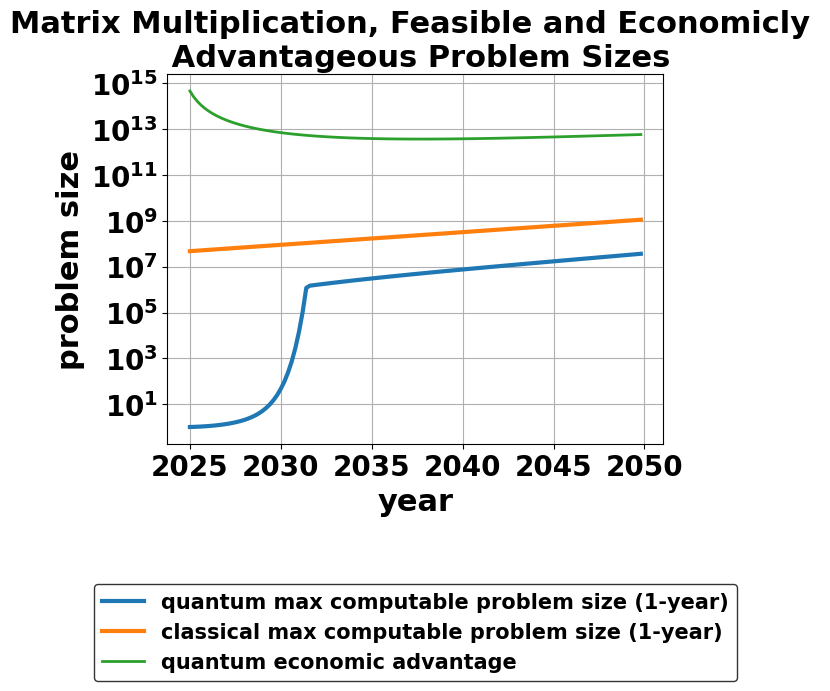

In [91]:
classical_runtime = "n**2.8"
quantum_runtime = "n**2"
# graph largeset problem size vs year for grovers algorithms
years = np.arange(2025, 2050, .2)
quantum_problem_sizes = [
    find_largest_problem_size(quantum_runtime, year, quantum=True) for year in years
]
classical_problem_sizes = [
    find_largest_problem_size(classical_runtime, year, quantum=False) for year in years
]
quantum_problem_sizes_google = [
    find_largest_problem_size(quantum_runtime, year, quantum=True, roadmap=Google_roadmap) for year in years
]
quantum_advantage_size_by_year_list= [
    quantum_advantage_size_by_year(year, classical_runtime_string=classical_runtime, quantum_runtime_string=quantum_runtime) for year in years
]

# plt.figure(1)
plt.xticks(fontsize=20, fontweight='bold')
tick_position = np.logspace(0, 15, num=4, base=10)
plt.yticks(tick_position, fontsize=20, fontweight='bold')

plt.plot(years, quantum_problem_sizes, label="quantum max computable problem size (1-year)", linewidth=3)
plt.plot(years, classical_problem_sizes, label="classical max computable problem size (1-year)", linewidth=3)
plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=2)
plt.ylabel("problem size", fontsize=22, fontweight='bold')
plt.xlabel("year", fontsize=22, fontweight='bold')
plt.yscale("log")
plt.grid()

plt.legend(
          loc='lower center',
          bbox_to_anchor=(0.5, -0.67),
          frameon=True,  # Adds a frame around the legend
          facecolor='white',  # White background
          edgecolor='black', prop=font_properties)
plt.title("Matrix Multiplication, Feasible and Economicly \n Advantageous Problem Sizes", fontsize=22, fontweight='bold')
plt.savefig("Figures/MM_IBM.png", dpi=300, bbox_inches='tight')




# Second plot
#====================================================================================
# plt.figure(2)
# plt.plot(years, quantum_problem_sizes_google, label="quantum max computable problem size (1-year)", linewidth=3)
# plt.plot(years, classical_problem_sizes, label="classical max computable problem size (1-year)", linewidth=3)
# plt.plot(years, quantum_advantage_size_by_year_list, label="quantum economic advantage", linewidth=3)
# plt.ylabel("problem size", fontsize=22, fontweight='bold')
# plt.xlabel("year", fontsize=22, fontweight='bold')
# plt.grid()
# # Set ticks for the second plot AFTER creating it
# plt.xticks(fontsize=20, fontweight='bold')
# plt.yticks(tick_position, fontsize=20, fontweight='bold')
# plt.yscale("log")

# plt.show()



In [237]:
print([10**i for i in range(0, 15, 5)])
print(np.logspace(0, 15, num=4, base=10))

[1, 100000, 10000000000]
[1.e+00 1.e+05 1.e+10 1.e+15]


# Sensitivity Analaysis

## Sensitivity Error Reduction Rate

In [280]:
# find the intersection of quantum max computable problem size and quantum economic advantage use binary search intersection 
error_reduction_rate = .2
gate_speed_improvement_rate = .15
classical_speed_init = 1/(5*1e9) # seconds
superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds
initial_error = 10**(-2.5)
classical_speed_improvement_rate = .3
number_of_processors = 1e5


# First runtime pair: n vs n^0.5
# Define runtime pairs
runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]

def get_intersection_year(quantum_runtime, classical_runtime, start_year=2024, end_year=2030):
    """Find intersection year for given runtime pair"""
    def find_largest_size(year):
        return find_largest_problem_size(quantum_runtime, year, quantum=True)
        
    def quantum_advantage_size(year):
        return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)
        
    return binary_search_intersection(find_largest_size, quantum_advantage_size, start_year, end_year)

# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
error_reduction_ranges = np.arange(0.1, 0.9, 0.1)
intersection_results = {name: [] for _, _, name in runtime_pairs}

for error_rate in error_reduction_ranges:
    error_reduction_rate = error_rate
    
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=2024, end_year=2050)
        intersection_results[name].append(year)

Initial intersection year for Grover's Algorithm: 2029.999994277954
Initial intersection year for Exponential Speedup: 2029.999994277954
Initial intersection year for Matrix Multiplication: 2029.999994277954


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_31845/3273130588.py:33: RuntimeWarning: overflow encountered in scalar power
  return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)


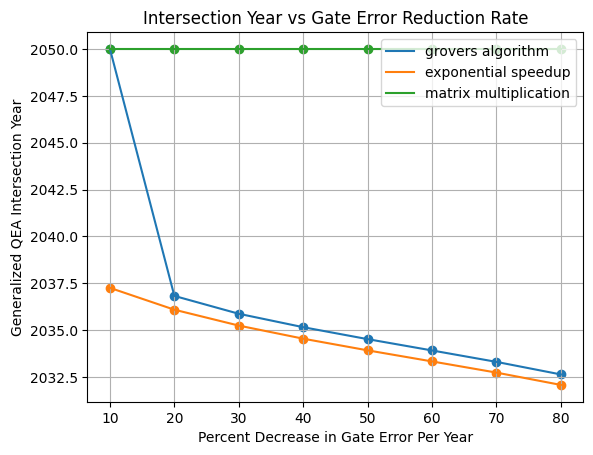

In [281]:
#now plot the intersection years vs error reduction
plt.plot(error_reduction_ranges*100, intersection_results["Grover's Algorithm"], label="grovers algorithm")
plt.scatter(error_reduction_ranges*100, intersection_results["Grover's Algorithm"])
plt.plot(error_reduction_ranges*100, intersection_results["Exponential Speedup"], label="exponential speedup")
plt.scatter(error_reduction_ranges*100, intersection_results["Exponential Speedup"])
plt.plot(error_reduction_ranges*100, intersection_results["Matrix Multiplication"], label="matrix multiplication")
plt.scatter(error_reduction_ranges*100, intersection_results["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Percent Decrease in Gate Error Per Year")
plt.title("Intersection Year vs Gate Error Reduction Rate")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("Figures/intersection_year_vs_error_reduction_rate.png")
plt.show()


## Sensitivity to Gate Speed Improvement

In [282]:
# find the intersection of quantum max computable problem size and quantum economic advantage use binary search intersection 
error_reduction_rate = .2
gate_speed_improvement_rate = .15
classical_speed_init = 1/(5*1e9) # seconds
superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds
initial_error = 10**(-2.5)
classical_speed_improvement_rate = .3
number_of_processors = 1e5


# First runtime pair: n vs n^0.5
# Define runtime pairs
runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]
# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
speed_improvement_ranges = np.arange(0.1, 0.9, 0.1)
intersection_results = {name: [] for _, _, name in runtime_pairs}

for speed_improvement in speed_improvement_ranges:
    gate_speed_improvement_rate = speed_improvement
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=2024, end_year=2050)
        intersection_results[name].append(year)


Initial intersection year for Grover's Algorithm: 2029.999994277954
Initial intersection year for Exponential Speedup: 2029.999994277954
Initial intersection year for Matrix Multiplication: 2029.999994277954


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_31845/3273130588.py:33: RuntimeWarning: overflow encountered in scalar power
  return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)


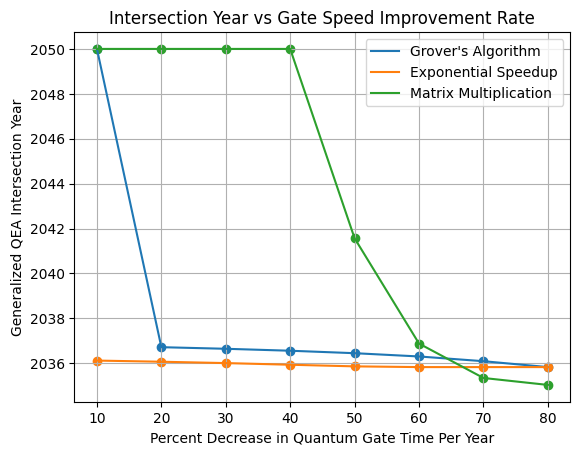

In [283]:

plt.plot(speed_improvement_ranges*100, intersection_results["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(speed_improvement_ranges*100, intersection_results["Grover's Algorithm"])
plt.plot(speed_improvement_ranges*100, intersection_results["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(speed_improvement_ranges*100, intersection_results["Exponential Speedup"])
plt.plot(speed_improvement_ranges*100, intersection_results["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(speed_improvement_ranges*100, intersection_results["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Percent Decrease in Quantum Gate Time Per Year")
plt.title("Intersection Year vs Gate Speed Improvement Rate")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_gate_speed_improvement_rate.png")
plt.show()



In [284]:
# Analyze intersection years for different classical improvement rates and algorithm types

error_reduction_rate = .2
gate_speed_improvement_rate = .15
classical_speed_init = 1/(5*1e9) # seconds
superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds
initial_error = 10**(-2.5)
classical_speed_improvement_rate = .3
number_of_processors = 1e5

# First runtime pair: n vs n^0.5
# Define runtime pairs
runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]
# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
classical_improvement_rates = np.arange(0.1, 0.9, 0.1)
intersection_results = {name: [] for _, _, name in runtime_pairs}

for classical_improvement_rate in classical_improvement_rates:
    classical_speed_improvement_rate = classical_improvement_rate
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=2024, end_year=2050)
        intersection_results[name].append(year)


Initial intersection year for Grover's Algorithm: 2029.999994277954
Initial intersection year for Exponential Speedup: 2029.999994277954
Initial intersection year for Matrix Multiplication: 2029.999994277954


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_31845/3273130588.py:33: RuntimeWarning: overflow encountered in scalar power
  return min(2**(exp_func(x, *popt)/surf_overhead), MAX_PROBLEM_SIZE)


Text(0.5, 1.0, 'Intersection Year vs Classical Improvement Rate for Different Runtime Complexities')

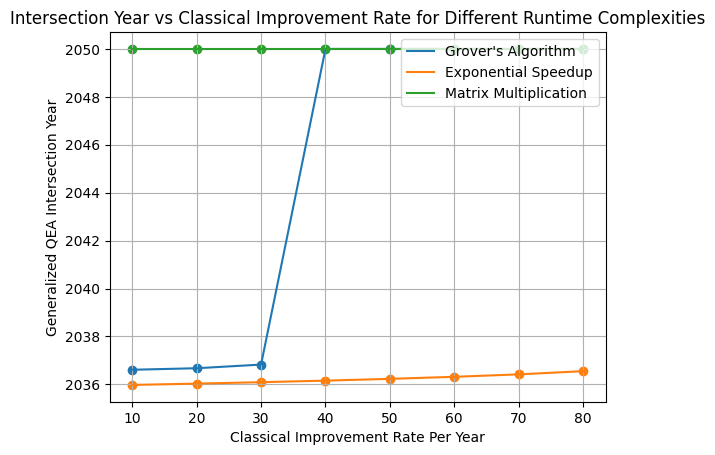

In [285]:
plt.plot(classical_improvement_rates*100, intersection_results["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(classical_improvement_rates*100, intersection_results["Grover's Algorithm"])
plt.plot(classical_improvement_rates*100, intersection_results["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(classical_improvement_rates*100, intersection_results["Exponential Speedup"])
plt.plot(classical_improvement_rates*100, intersection_results["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(classical_improvement_rates*100, intersection_results["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Classical Improvement Rate Per Year")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_classical_improvement_rate.png")
plt.title("Intersection Year vs Classical Improvement Rate for Different Runtime Complexities")